#Setup

In [3]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import io
import base64
from io import BytesIO
from PIL import Image

In [10]:
class LogScale:
    """Converts SVG coordinates into data coordinates"""

    def __init__(self, svg_range, data_range):
        self.svg_range = np.array(svg_range)
        self.data_range = np.array(data_range)

    def get_coord(self, svg_coord):
        alpha = (svg_coord - self.svg_range[0])/(self.svg_range[1] - self.svg_range[0])
        data_coord = self.data_range[0] * (self.data_range[1]/self.data_range[0])**alpha
        return data_coord

In [7]:
with open('chinchilla_figure_4.svg', 'r') as f:
    svg_content = f.read()

# Extract position data from SVG


In [8]:
# Parse the SVG data with BeautifulSoup
soup = BeautifulSoup(svg_content, 'xml')

# Get the group of points on the left plot
left_scatter_group = soup.find('g', {'id': 'left-points'})

# Get all points in the group
left_scatter_points = left_scatter_group.find_all('g', {'clip-path': True})

# Create lists to store the extracted data
x_values = []
y_values = []
colors = []

# Extract location and color for each scatter point
for point in left_scatter_points:
    # Check if the <g> element contains exactly two <path> elements
    paths = point.find_all('path')
    if len(paths) == 2:
        # Extract the fill color from the first <path>
        color = paths[0].get('fill')

        # Extract the position from the transform attribute of the first <path>
        transform = paths[0].get('transform')
        if transform:
            # Use regular expression to extract x and y values
            match = re.search(r'matrix\(1,0,0,-1,(\d+\.?\d*),(\d+\.?\d*)\)', transform)
            if match:
                x = float(match.group(1))
                y = float(match.group(2))

                # Append the extracted data to the respective lists
                x_values.append(x)
                y_values.append(y)
                colors.append(color)

# Create a DataFrame with the extracted data
df_left = pd.DataFrame({'x': x_values, 'y': y_values, 'color': colors})
df_left.head()

,x,y,color
0,154.03592,140.63364,#faebdd
1,151.60375,175.51709,#f8d1b8
2,153.29233,180.65761,#f47a54
3,152.88216,186.78615,#f47d57
4,153.35068,192.24076,#ed503e


In [19]:
# Convert from SVG coordinates to data coordinates

# Y scale
y_tick_svg_coords = [26.872, 66.113, 124.290, 221.707, 319.125]
y_tick_data_coords = [100e9, 40e9, 10e9, 1e9, 100e6]

#y_tick_svg_coords = [26.872, 66.113, 125.4823, 224.0927, 322.703] # corrected from https://shape-of-code.com/2024/04/28/chinchilla-scaling-a-replication-using-the-pdf/
#y_tick_data_coords = [100e9, 40e9, 10e9, 1e9, 100e6]

y_scale = LogScale([y_tick_svg_coords[0], y_tick_svg_coords[-1]], [y_tick_data_coords[0], y_tick_data_coords[-1]])

# Check scale
print('y_scale:')
for svg_coord, data_coord in zip(y_tick_svg_coords, y_tick_data_coords):
    print(f"  {svg_coord}px -> {y_scale.get_coord(svg_coord):.2e} (expected: {data_coord:.2e})")
print()

# X scale
x_tick_svg_coords = [83.856, 154.055, 224.254, 294.452]
x_tick_data_coords = [1e18, 1e19, 1e20, 1e21]
x_scale = LogScale([x_tick_svg_coords[0], x_tick_svg_coords[-1]], [x_tick_data_coords[0], x_tick_data_coords[-1]])

# Check scale
print('x_scale:')
for svg_coord, data_coord in zip(x_tick_svg_coords, x_tick_data_coords):
    print(f"  {svg_coord}px -> {x_scale.get_coord(svg_coord):.2e} (expected: {data_coord:.2e})")
print()

df_left['model size'] = df_left['y'].apply(y_scale.get_coord)
df_left['compute_budget'] = df_left['x'].apply(x_scale.get_coord)

df_left
df_left.head()

y_scale:
  26.872px -> 1.00e+11 (expected: 1.00e+11)
  66.113px -> 3.96e+10 (expected: 4.00e+10)
  124.29px -> 1.00e+10 (expected: 1.00e+10)
  221.707px -> 1.00e+09 (expected: 1.00e+09)
  319.125px -> 1.00e+08 (expected: 1.00e+08)

x_scale:
  83.856px -> 1.00e+18 (expected: 1.00e+18)
  154.055px -> 1.00e+19 (expected: 1.00e+19)
  224.254px -> 1.00e+20 (expected: 1.00e+20)
  294.452px -> 1.00e+21 (expected: 1.00e+21)



,x,y,color,model size,compute_budget
0,154.03592,140.63364,#faebdd,6.795600e+09,9.993853e+18
1,151.60375,175.51709,#f8d1b8,2.979521e+09,9.227541e+18
2,153.29233,180.65761,#f47a54,2.638631e+09,9.753047e+18
3,152.88216,186.78615,#f47d57,2.282804e+09,9.622708e+18
4,153.35068,192.24076,#ed503e,2.006673e+09,9.771731e+18


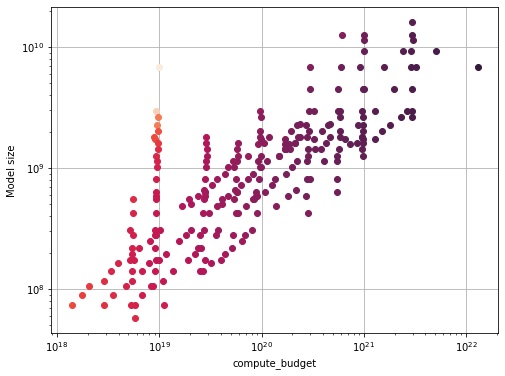

In [20]:
plt.figure(figsize=(8, 6))
for i, row in df_left.iterrows():
      plt.scatter(row['compute_budget'], row['model size'], color=row['color'])
plt.xlabel('compute_budget')
plt.ylabel('Model size')
plt.yscale('log')
plt.xscale('log')
plt.title('')
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.show()


# Color scheme to loss mapping

In [21]:
# Extract the base64 data from the provided string
loss_bar = soup.find('image', {'id': 'image_308'})
base64_data = loss_bar.get('xlink:href').split(',')[1]

# Decode the base64 data to binary
binary_data = base64.b64decode(base64_data)

# Create a BytesIO object from the binary data
img_bytes = BytesIO(binary_data)

# Load the image using Pillow
img = Image.open(img_bytes)

# Display the image
img

In [22]:
# Loss scale
tick_svg_coords = [26.872, 101.343, 197.353, 332.671]
tick_data_coords = [5, 4, 3, 2]
loss_scale = LogScale([tick_svg_coords[0], tick_svg_coords[-1]], [tick_data_coords[0], tick_data_coords[-1]])

# Check scale
print('loss_scale:')
for svg_coord, data_coord in zip(tick_svg_coords, tick_data_coords):
    print(f"  {svg_coord}px -> {loss_scale.get_coord(svg_coord):.2f} (expected: {data_coord:.2f})")

# Position of the top of the image
match = re.search(r'matrix\(1,0,0,1,(\d+\.?\d*),(\d+\.?\d*)\)', loss_bar.parent.get('transform'))
img_y = float(match.group(2))

# Choose a specific width position (x value), here we take the middle of the image
x = img.width // 2

# Initialize a list to hold the hex values and their corresponding height
hex_values = []

# Loop through each pixel along the height at this x position
for y in range(img.height):
    # Get the RGB value of the pixel
    pixel = img.getpixel((x, y))
    # Convert RGB to hex, slicing to skip the alpha value if present
    hex_value = '#{:02x}{:02x}{:02x}'.format(*pixel[:3])
    hex_values.append([y, hex_value, loss_scale.get_coord(y + img_y)])

# Create a DataFrame from the hex values with a column for the pixel height and hex color
df_color = pd.DataFrame(hex_values, columns=['pixel_height', 'hex_color', 'loss_value'])

# Display the DataFrame
df_color # Show the first few rows of the dataframe to check

loss_scale:
  26.872px -> 5.00 (expected: 5.00)
  101.343px -> 4.00 (expected: 4.00)
  197.353px -> 3.00 (expected: 3.00)
  332.671px -> 2.00 (expected: 2.00)


,pixel_height,hex_color,loss_value
0,0,#faebdd,5.013081
1,1,#faebdd,4.998083
2,2,#fae9da,4.983129
3,3,#fae9da,4.968220
4,4,#fae8d8,4.953356
...,...,...,...
337,337,#06071c,1.826260
338,338,#05061b,1.820796
339,339,#04051a,1.815348
340,340,#04051a,1.809917


In [23]:
# Group by hex_color and find pairs with the same hex_color
groups = df_color.groupby('hex_color')

# Initialize variables to track the maximum difference and the corresponding pair of points
max_diff = 0
pair_with_max_diff = None

for color, group in groups:
    # If there's at least two points with the same color, calculate differences
    if len(group) > 1:
        for i in range(len(group) - 1):
            for j in range(i + 1, len(group)):
                diff = abs(group.iloc[i]['loss_value'] - group.iloc[j]['loss_value'])
                if diff > max_diff:
                    max_diff = diff
                    pair_with_max_diff = (group.iloc[i], group.iloc[j])

pair_with_max_diff, max_diff

((pixel_height           0
  hex_color        #faebdd
  loss_value      5.013081
  Name: 0, dtype: object,
  pixel_height           1
  hex_color        #faebdd
  loss_value      4.998083
  Name: 1, dtype: object),
 0.014998626415124505)

In [24]:
# Group df_color by 'hex_color' and calculate the median 'loss_value' for each color
color_loss_median = df_color.groupby('hex_color')['loss_value'].median().reset_index()

# Merge the median loss values with df_left based on color
df_left_merged = pd.merge(df_left, color_loss_median, how='left', left_on='color', right_on='hex_color')
df_left_merged

,x,y,color,model size,compute_budget,hex_color,loss_value
0,154.03592,140.63364,#faebdd,6.795600e+09,9.993853e+18,#faebdd,5.005582
1,151.60375,175.51709,#f8d1b8,2.979521e+09,9.227541e+18,#f8d1b8,4.665232
2,153.29233,180.65761,#f47a54,2.638631e+09,9.753047e+18,#f47a54,3.765563
3,152.88216,186.78615,#f47d57,2.282804e+09,9.622708e+18,#f47d57,3.793872
4,153.35068,192.24076,#ed503e,2.006673e+09,9.771731e+18,#ed503e,3.446995
...,...,...,...,...,...,...,...
240,302.37174,198.50406,#591e50,1.730547e+09,1.296639e+21,#591e50,2.286446
241,312.28760,186.78606,#531e4d,2.282809e+09,1.795036e+21,#531e4d,2.249076
242,319.95230,180.65752,#4e1d4b,2.638636e+09,2.308123e+21,#4e1d4b,2.222281
243,323.82795,175.51700,#4c1d4b,2.979528e+09,2.621011e+21,#4c1d4b,2.212313


# Save CSV

In [25]:
df_left_merged

,x,y,color,model size,compute_budget,hex_color,loss_value
0,154.03592,140.63364,#faebdd,6.795600e+09,9.993853e+18,#faebdd,5.005582
1,151.60375,175.51709,#f8d1b8,2.979521e+09,9.227541e+18,#f8d1b8,4.665232
2,153.29233,180.65761,#f47a54,2.638631e+09,9.753047e+18,#f47a54,3.765563
3,152.88216,186.78615,#f47d57,2.282804e+09,9.622708e+18,#f47d57,3.793872
4,153.35068,192.24076,#ed503e,2.006673e+09,9.771731e+18,#ed503e,3.446995
...,...,...,...,...,...,...,...
240,302.37174,198.50406,#591e50,1.730547e+09,1.296639e+21,#591e50,2.286446
241,312.28760,186.78606,#531e4d,2.282809e+09,1.795036e+21,#531e4d,2.249076
242,319.95230,180.65752,#4e1d4b,2.638636e+09,2.308123e+21,#4e1d4b,2.222281
243,323.82795,175.51700,#4c1d4b,2.979528e+09,2.621011e+21,#4c1d4b,2.212313


In [27]:
df_left_merged.rename(columns={
    'compute_budget': 'Training FLOP',
    'loss_value': 'loss',
    'model size': 'Model Size'
}, inplace=True)

# Import necessary libraries
import pandas as pd

# Assuming df_left_merged is your DataFrame
# Save the DataFrame to a CSV file
df_left_merged.to_csv('data/svg_extracted_data.csv', index=False)